# Directly importing a small chunk of dataset from the website and making a time series problem out of it with 4 features (including the lagged/previous velocities) and 3 lables (velocity, x, and y).
# Introduced 3 new coloums of future lables by shifting the target variable to create a column with the next label (next time step).
# Introduced splitting of the dataset into training, validation, and test sets (70-15-15 split)
# Tried to use an autoregressive LSTM model and make some future velocity predictions.
# Plotted the prediction results for the first 5 time steps

In [66]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [67]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [69]:
# Defining columns to use
columns_to_use = ["global_x", "global_y", "v_vel", "v_acc", "global_time"] #using just 4 of them

# Defining chunk size for reading data
chunk_size = 100

# Initializing an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
velocity_dataset = pd.concat(data_chunks, ignore_index=True)

# trajectory_dataset = pd.read_csv(
#     "https://data.transportation.gov/resource/8ect-6jqj.csv")

#   names=["Vehicle_ID", "Frame_Id", "Total_Frames", "Global_Time", "Local_X",
#            "Local_Y", "Global_X", "Global_Y", "v_length", "v_Width", "v_Vel", 
#            "v_Acc", "Lane_ID", "O_Zone", "D_Zone", "Int_ID", "Section_ID", "Direction",
#            "Movement", "Preceding", "Following", "Space_Headway", "Time_Headway", "Location"]

In [70]:
velocity_dataset.shape

(1000, 5)

In [71]:
velocity_dataset.head()

,global_time,global_x,global_y,v_vel,v_acc
0,1163368300,2230502.921,1375532.938,33.96,0.00
1,1163368200,2230503.114,1375537.934,33.96,0.00
2,1163368100,2230502.731,1375540.951,33.96,0.00
3,1163368000,2230502.906,1375544.692,33.96,10.82
4,1163051100,2230518.568,1375546.762,0.25,-4.89


In [72]:
velocity_dataset_sorted = velocity_dataset.sort_values(by='global_time')

In [73]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc
434,1163034800,2230519.322,1375566.277,17.29,0.0
503,1163034900,2230519.899,1375568.256,17.29,0.0
553,1163035000,2230519.957,1375569.755,17.29,0.0
710,1163035100,2230519.535,1375571.773,17.29,0.0
949,1163035200,2230520.612,1375573.733,17.29,0.0
...,...,...,...,...,...
528,1163849900,2230532.048,1375568.927,25.71,0.0
643,1163850000,2230532.204,1375571.494,25.71,0.0
563,1163850000,2230520.798,1375569.938,37.39,0.0
966,1163850100,2230532.360,1375574.060,25.71,0.0


In [74]:
# Shift the target variable to create a column with the next velocity (next time step)
velocity_dataset_sorted['v_vel_next'] = velocity_dataset_sorted['v_vel'].shift(-1)
velocity_dataset_sorted['x_next'] = velocity_dataset_sorted['global_x'].shift(-1)
velocity_dataset_sorted['y_next'] = velocity_dataset_sorted['global_y'].shift(-1)

# Drop the last row since it will have NaN in the next velocity column
velocity_dataset_sorted = velocity_dataset_sorted.dropna()

In [75]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc,v_vel_next,x_next,y_next
434,1163034800,2230519.322,1375566.277,17.29,0.0,17.29,2230519.899,1375568.256
503,1163034900,2230519.899,1375568.256,17.29,0.0,17.29,2230519.957,1375569.755
553,1163035000,2230519.957,1375569.755,17.29,0.0,17.29,2230519.535,1375571.773
710,1163035100,2230519.535,1375571.773,17.29,0.0,17.29,2230520.612,1375573.733
949,1163035200,2230520.612,1375573.733,17.29,0.0,25.79,2230519.819,1375553.248
...,...,...,...,...,...,...,...,...
431,1163849900,2230520.543,1375566.206,37.39,0.0,25.71,2230532.048,1375568.927
528,1163849900,2230532.048,1375568.927,25.71,0.0,25.71,2230532.204,1375571.494
643,1163850000,2230532.204,1375571.494,25.71,0.0,37.39,2230520.798,1375569.938
563,1163850000,2230520.798,1375569.938,37.39,0.0,25.71,2230532.360,1375574.060


In [76]:
input_features = ["global_x", "global_y", "v_acc", "v_vel"]
output_labels = ["v_vel_next", "x_next", "y_next"]

In [77]:
# Split the dataset into training (70%) and temp (30% for validation and test)
train_data, temp_data = train_test_split(velocity_dataset_sorted, test_size=0.3, random_state=42)

# Split the temp dataset into validation (15% of total) and test (15% of total)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate features and labels for training set
train_features = train_data[input_features]
train_labels = train_data[output_labels]

# Separate features and labels for validation set
validation_features = validation_data[input_features]
validation_labels = validation_data[output_labels]

# Separate features and labels for test set
test_features = test_data[input_features]
test_labels = test_data[output_labels]

# Print the shapes of the splits to verify
print("Training features shape:", train_features.shape)
print("Training labels shape:", train_labels.shape)
print("Validation features shape:", validation_features.shape)
print("Validation labels shape:", validation_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Training features shape: (699, 4)
Training labels shape: (699, 3)
Validation features shape: (150, 4)
Validation labels shape: (150, 3)
Test features shape: (150, 4)
Test labels shape: (150, 3)


In [78]:
test_features

,global_x,global_y,v_acc,v_vel
281,2230521.562,1375560.030,0.00,3.09
845,2230522.742,1375573.150,-2.67,10.10
23,2230518.642,1375547.912,0.89,3.74
377,2230531.755,1375564.295,0.00,33.03
844,2230521.791,1375573.106,0.00,1.07
...,...,...,...,...
478,2230521.379,1375567.698,0.00,5.70
333,2230530.205,1375562.789,-11.37,20.76
854,2230521.452,1375573.187,0.00,24.45
252,2230519.322,1375558.367,0.00,3.74


In [79]:
test_labels

,v_vel_next,x_next,y_next
281,3.09,2230521.573,1375560.340
845,31.42,2230519.400,1375568.275
23,3.78,2230518.666,1375548.285
377,33.03,2230531.352,1375566.812
844,1.07,2230521.786,1375573.213
...,...,...,...
478,5.70,2230521.418,1375568.698
333,16.50,2230530.265,1375564.538
854,32.97,2230521.859,1375567.179
252,3.74,2230519.346,1375558.740


In [80]:
# Normalize the features
feature_normalizer = tf.keras.layers.Normalization(axis=-1)
feature_normalizer.adapt(np.array(train_features))

train_features_normalized = feature_normalizer(np.array(train_features))
validation_features_normalized = feature_normalizer(np.array(validation_features))
test_features_normalized = feature_normalizer(np.array(test_features))

# Normalize the labels
label_normalizer = tf.keras.layers.Normalization(axis=-1)
label_normalizer.adapt(np.array(train_labels))

train_labels_normalized = label_normalizer(np.array(train_labels))
validation_labels_normalized = label_normalizer(np.array(validation_labels))
test_labels_normalized = label_normalizer(np.array(test_labels))

In [81]:
# Store mean and variance for denormalization
feature_mean = feature_normalizer.mean.numpy()
feature_variance = feature_normalizer.variance.numpy()

label_mean = label_normalizer.mean.numpy()
label_variance = label_normalizer.variance.numpy()

In [86]:
# Prepare the input and output for LSTM
X_train, y_train = [], []
X_validation, y_validation = [], []
X_test, y_test = [], []

# Create training data
for i in range(1, len(train_features_normalized)):
    X_train.append(train_features_normalized[i-1])
    y_train.append(train_labels_normalized[i])

# Create validation data
for i in range(1, len(validation_features_normalized)):
    X_validation.append(validation_features_normalized[i-1])
    y_validation.append(validation_labels_normalized[i])

# Create testing data
for i in range(1, len(test_features_normalized)):
    X_test.append(test_features_normalized[i-1])
    y_test.append(test_labels_normalized[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the features for LSTM [num_samples, time steps, num_features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [87]:
# # Prepare the input and output for LSTM
# def create_sequences(features, labels):
#     X, y = [], []
#     for i in range(1, len(features)):
#         X.append(features[i-1])
#         y.append(labels[i])
#     return np.array(X), np.array(y)

# X_train, y_train = create_sequences(train_features_normalized, train_labels_normalized)
# X_validation, y_validation = create_sequences(validation_features_normalized, validation_labels_normalized)
# X_test, y_test = create_sequences(test_features_normalized, test_labels_normalized)

In [95]:
# Define the LSTM model (here the input shape is (1,4))
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(3)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}") # Aggregated value

Epoch 1/100
22/22 [==============================] - 8s 56ms/step - loss: 0.9974 - val_loss: 1.0466
Epoch 2/100
22/22 [==============================] - 0s 19ms/step - loss: 0.9973 - val_loss: 1.0465
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.9972 - val_loss: 1.0462
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 0.9972 - val_loss: 1.0463
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.9972 - val_loss: 1.0462
Epoch 6/100
22/22 [==============================] - 0s 17ms/step - loss: 0.9972 - val_loss: 1.0461
Epoch 7/100
22/22 [==============================] - 0s 18ms/step - loss: 0.9972 - val_loss: 1.0460
Epoch 8/100
22/22 [==============================] - 0s 17ms/step - loss: 0.9972 - val_loss: 1.0460
Epoch 9/100
22/22 [==============================] - 0s 20ms/step - loss: 0.9971 - val_loss: 1.0458
Epoch 10/100
22/22 [==============================] - 0s 20ms/step - loss: 0.9971 - val_loss: 1.0459

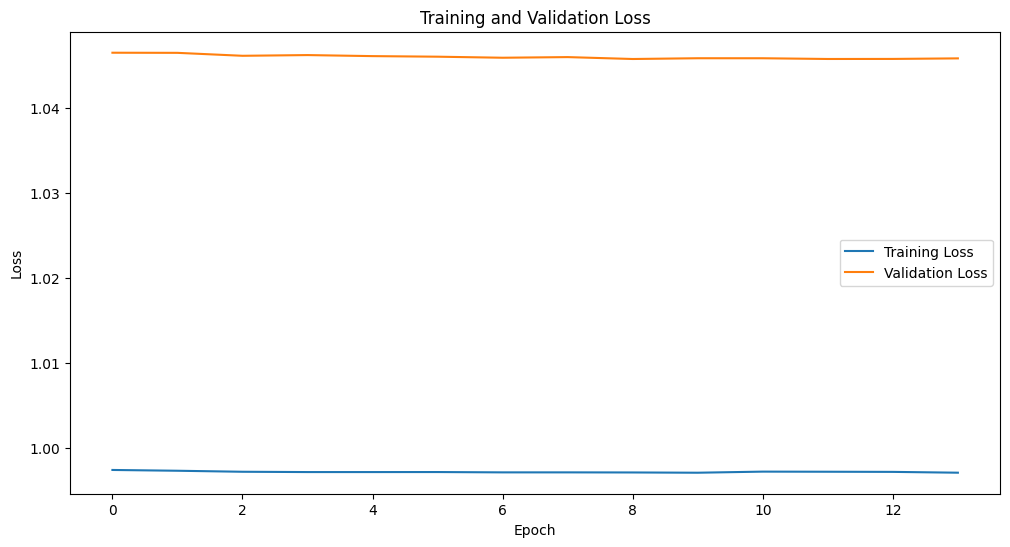

In [98]:
# Plot training and validation loss to check for overfitting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [96]:
# Predict the first 5 time steps
n_steps = 5
predicted_values = []
current_input = X_test[0].reshape(1, 1, X_test.shape[2])  # Start with the first test sample

for i in range(n_steps):
    current_pred = lstm_model.predict(current_input, verbose=0)
    predicted_values.append(current_pred[0])  # Append the current prediction

    if i < len(X_test) - 1:
        # Update the current input with the predicted values
        next_input = X_test[i + 1].copy().reshape(1, 1, X_test.shape[2])
        next_input[0, 0, 0] = current_pred[0][1]  # Update global_x with the predicted x_next
        next_input[0, 0, 1] = current_pred[0][2]  # Update global_y with the predicted y_next
        next_input[0, 0, -1] = current_pred[0][0]  # Update v_vel with the predicted v_vel_next
        current_input = next_input

predicted_values = np.array(predicted_values)

# Denormalize the predictions
predicted_values_denorm = predicted_values * np.sqrt(label_variance) + label_mean

# Calculate errors for velocity predictions
true_values = y_test[:n_steps]
true_values_denorm = true_values * np.sqrt(label_variance) + label_mean
errors = predicted_values_denorm[:, 0] - true_values_denorm[:, 0]

# Print errors
for i in range(n_steps):
    print(f"Time Step {i+1} - Predicted Velocity: {predicted_values_denorm[i, 0]}, True Velocity: {true_values_denorm[i, 0]}, Error: {errors[i]}")

Time Step 1 - Predicted Velocity: 10.264961242675781, True Velocity: 31.420001983642578, Error: -21.155040740966797
Time Step 2 - Predicted Velocity: 10.264970779418945, True Velocity: 3.7799997329711914, Error: 6.484971046447754
Time Step 3 - Predicted Velocity: 10.264947891235352, True Velocity: 33.029998779296875, Error: -22.765050888061523
Time Step 4 - Predicted Velocity: 10.264955520629883, True Velocity: 1.0699996948242188, Error: 9.194955825805664
Time Step 5 - Predicted Velocity: 10.264955520629883, True Velocity: 0.23999977111816406, Error: 10.024955749511719


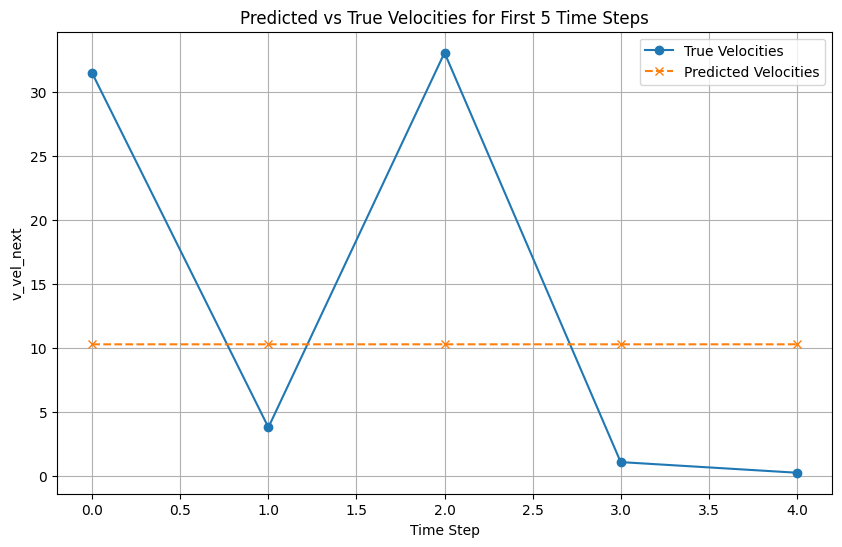

In [97]:
# Plot the results for the first 5 time steps
plt.figure(figsize=(10, 6))
plt.plot(range(n_steps), true_values_denorm[:, 0], label='True Velocities', marker='o', linestyle='-', markersize=6)
plt.plot(range(n_steps), predicted_values_denorm[:, 0], label='Predicted Velocities', marker='x', linestyle='--', markersize=6)
plt.xlabel('Time Step')
plt.ylabel('v_vel_next')
plt.title('Predicted vs True Velocities for First 5 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Find the index of the maximum velocity
max_index = velocity_dataset['v_vel'].idxmax()

# Find the maximum velocity itself
max_velocity = velocity_dataset.loc[max_index, 'v_vel']

print(f"Maximum velocity: {max_velocity}")
print(f"Index of maximum velocity: {max_index}")

Maximum velocity: 51.3
Index of maximum velocity: 75
